<a href="https://colab.research.google.com/github/caitline27/APS360_work/blob/master/Lab_2_Cats_vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Cats vs Dogs

**Deadline**: May 28, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Marking TA**: Tinglin (Francis) Duan

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://drive.google.com/file/d/1DYHmn49_DHc1ZFyTnQGy_KzuPsLkutZq/view?usp=sharing


In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

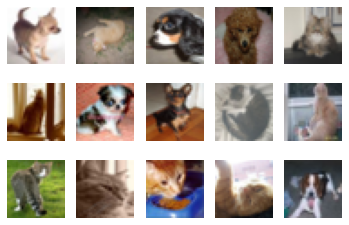

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [ ]:
print('training : ', len(train_loader))
print('validation : ', len(val_loader))
print('test examples : ', len(test_loader))


training :  8000
validation :  2000
test examples :  2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

In [ ]:

#the validation dataset is used to tune the hyperparameters of the model. In addition, when training model as this data set contains
# data the model has not seen (or yet since the training has been used)
#if we jusge the performance of model using training set then it is not generlaized enough
#the training set is what is used to build the model and teach it
#we use the validation set to see if the model has learned and is able to apply what we want
#and then tune the parameters to see what will yield the most accurate combination

#tuning is useful because we can attempt to create the best model before
#feeding the testing dataset to the model, which we want to limit exposure to



## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
print("numbers in each small tensor : ")
count_small = 0
count_large = 0
for param in small_net.parameters():
    print(param.shape)
    
    for i in param:
      count_small+=1
      print( i.numel())
    print(" \n number of tensors", count_small)

print("\n number in each large tensor: ")
for param in large_net.parameters():
    print(param.shape)
    for j in param:
      count_large+=1
      print(j.numel())
    print(" \n number of tensors", count_large)

#The total # of parameters in both small and large net is : 10058

#weights and biases, can also manually add up


numbers in each small tensor : 
torch.Size([5, 3, 3, 3])
27
27
27
27
27
 
 number of tensors 5
torch.Size([5])
1
1
1
1
1
 
 number of tensors 10
torch.Size([1, 245])
245
 
 number of tensors 11
torch.Size([1])
1
 
 number of tensors 12

 number in each large tensor: 
torch.Size([5, 3, 5, 5])
75
75
75
75
75
 
 number of tensors 5
torch.Size([5])
1
1
1
1
1
 
 number of tensors 10
torch.Size([10, 5, 5, 5])
125
125
125
125
125
125
125
125
125
125
 
 number of tensors 20
torch.Size([10])
1
1
1
1
1
1
1
1
1
1
 
 number of tensors 30
torch.Size([32, 250])
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
 
 number of tensors 62
torch.Size([32])
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
 
 number of tensors 94
torch.Size([1, 32])
32
 
 number of tensors 95
torch.Size([1])
1
 
 number of tensors 96


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

In [ ]:
#defaults *found in provided code: 
#bach_size default = 64
#learning_rate default = 0.01
#num_epochs = 30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
train_net(small_net, num_epochs=5)
#list of files written to disk:

#model_small_bs64_lr0.01_epoch4_train_err.csv
#a csv file with the training error

#model_small_bs64_lr0.01_epoch4_train_loss.csv
#a csv file with the training data loss

#model_small_bs64_lr0.01_epoch4_val_err.csv
#a csv file with the validation error

#model_small_bs64_lr0.01_epoch4_val_loss.csv
#a csv file with the validation data loss




Files already downloaded and verified
Files already downloaded and verified


/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


Epoch 1: Train err: 0.435625, Train loss: 0.6780135622024536 |Validation err: 0.369, Validation loss: 0.6537684705108404
Epoch 2: Train err: 0.3685, Train loss: 0.6427974605560303 |Validation err: 0.3705, Validation loss: 0.6567860674113035
Epoch 3: Train err: 0.34525, Train loss: 0.6260698781013488 |Validation err: 0.3455, Validation loss: 0.6244371235370636
Epoch 4: Train err: 0.340625, Train loss: 0.6142594494819641 |Validation err: 0.3615, Validation loss: 0.6347209140658379
Epoch 5: Train err: 0.33025, Train loss: 0.6088262431621552 |Validation err: 0.337, Validation loss: 0.619620181620121
Finished Training
Total time elapsed: 16.87 seconds


### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#total elapsed time when training each network
#smallnet: Total time elapsed: 97.58 seconds
train_net(small_net)

#largenet : Total time elapsed: 110.90 seconds
train_net(large_net)

#the larger network took longer to train because its tensors have more values
#and the parameters are larger in size
#the network is overall larger and therefore more time to train



Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.32625, Train loss: 0.6023949294090271 |Validation err: 0.3395, Validation loss: 0.6193784791976213
Epoch 2: Train err: 0.320875, Train loss: 0.5975395267009735 |Validation err: 0.3405, Validation loss: 0.624966086819768
Epoch 3: Train err: 0.313375, Train loss: 0.5921418251991272 |Validation err: 0.3295, Validation loss: 0.60903025791049
Epoch 4: Train err: 0.310875, Train loss: 0.5854011752605438 |Validation err: 0.3385, Validation loss: 0.6139704883098602
Epoch 5: Train err: 0.300625, Train loss: 0.5788782184123993 |Validation err: 0.3185, Validation loss: 0.6009244918823242
Epoch 6: Train err: 0.295625, Train loss: 0.5726274244785309 |Validation err: 0.3255, Validation loss: 0.610676858574152
Epoch 7: Train err: 0.303, Train loss: 0.5736173243522644 |Validation err: 0.307, Validation loss: 0.5905571803450584
Epoch 8: Train err: 0.290375, Train loss: 0.5645145032405853 |Validation err: 0

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

this is small data set


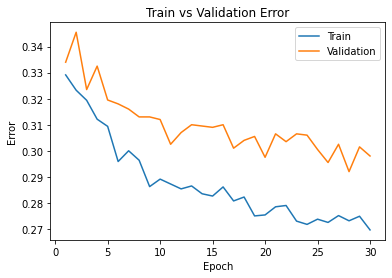

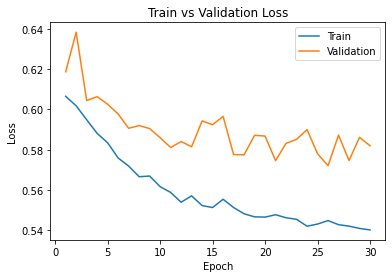

this is large data set


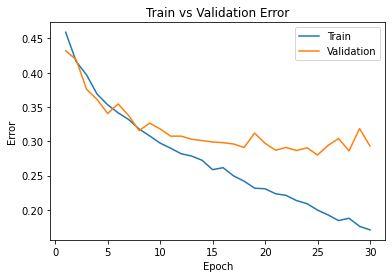

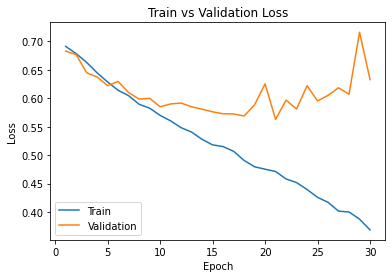

In [ ]:
print("this is small data set")
smodel_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(smodel_path)

print("this is large data set")
lmodel_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(lmodel_path)


### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

In [ ]:
#all 4 training curves are sloping down and to the right
#the large data set training curve is more linear than the small set

#background info from online on over and underfitting 
#Underfitting occurs when machine learning algorithm cannot capture the underlying trend of the data
#overfitting  occurs when a machine learning algorithm captures the noise of the data

#i believe there is underfitting present in the large data set
#the traaining and validation curve are very different, leading me to believe that the initial
#model did not capture the data trends well enough

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360023498535 |Validation err: 0.467, Validation loss: 0.6924686655402184
Epoch 2: Train err: 0.448625, Train loss: 0.6922589688301086 |Validation err: 0.4305, Validation loss: 0.6916493382304907
Epoch 3: Train err: 0.43575, Train loss: 0.6916067261695862 |Validation err: 0.4285, Validation loss: 0.6908544152975082
Epoch 4: Train err: 0.43, Train loss: 0.6908614072799683 |Validation err: 0.4245, Validation loss: 0.6896600145846605
Epoch 5: Train err: 0.434375, Train loss: 0.689919647693634 |Validation err: 0.4195, Validation loss: 0.6886944100260735
Epoch 6: Train err: 0.435875, Train loss: 0.6887412457466126 |Validation err: 0.4195, Validation loss: 0.6867826543748379
Epoch 7: Train err: 0.43675, Train loss: 0.6873777341842652 |Validation err: 0.418, Validation loss: 0.6851988434791565
Epoch 8: Train err: 0.437375, Train loss: 0.6859265742301941 |Validation err: 0.

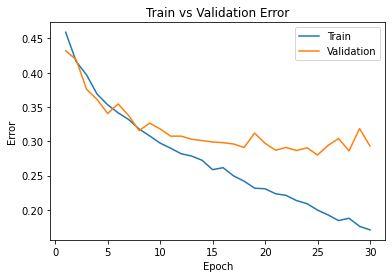

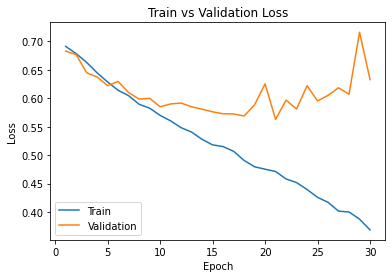

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, learning_rate=0.001)
# with new learning rate, Total time elapsed: 109.68 seconds
#this time is faster, with a lr=0.01 the training required 110.90 seconds

#however while the time to train was faster, this decrease in lr resulted in greater error (worse result) than the original LR
#as before the best val err was 0.29 and in this case it is 0.3785, more error in results


# generally, large learning rates = unstable training,  small rates = in a failure to train
#here the smaller learning rate decreases the time taken to train,
#indicating that it appropriately jumps from peaks and valleys along the curve

#plotting 
l2model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(l2model_path)





### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.426875, Train loss: 0.6742900676727295 |Validation err: 0.3695, Validation loss: 0.6364889536052942
Epoch 2: Train err: 0.361625, Train loss: 0.6373908457756042 |Validation err: 0.3655, Validation loss: 0.6439082939177752
Epoch 3: Train err: 0.371625, Train loss: 0.6370397086143493 |Validation err: 0.3515, Validation loss: 0.6133540160953999
Epoch 4: Train err: 0.348, Train loss: 0.6141975626945496 |Validation err: 0.3365, Validation loss: 0.6044933125376701
Epoch 5: Train err: 0.333875, Train loss: 0.6029216282367706 |Validation err: 0.3245, Validation loss: 0.5935317613184452
Epoch 6: Train err: 0.3175, Train loss: 0.5871682240962982 |Validation err: 0.324, Validation loss: 0.5884642750024796
Epoch 7: Train err: 0.308, Train loss: 0.5718630583286285 |Validation err: 0.3095, Validation loss: 0.5934673277661204
Epoch 8: Train err: 0.306625, Train loss: 0.5659790558815002 |Validation err: 0

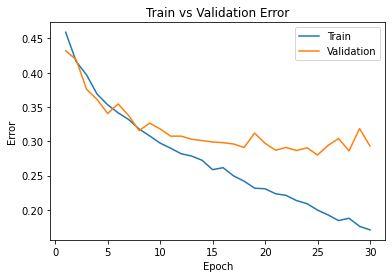

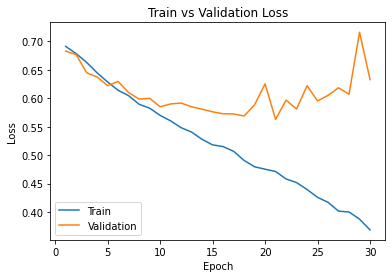

In [ ]:
large_net = LargeNet()
train_net(large_net, learning_rate=0.1)

#time elapsed with new learning rate (lr) is : 110.53
#this is faster than the original lr of 0.01 but still slower than a lr of 0.001

#plotting the training curve
l3model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(l3model_path)

#increasing the lr from 0.001 to 0.1 increased the time it took to train the data
#however, the time taken was still faster than the original lr of 0.01
#this demonstrates the effects of having to try various parameter values (ie lr),
#to see how the model reacts and what gives the best outcome

#however, this increase in lr resulted in greater error (worse result) than the original LR
#as before the best val err was 0.29 and in this case it is 0.301, more error in results

#ie in part a decreasing the lr had a positive effect on training time compared to the original lr,
#and in this case, increasing the lr also yields a better time than the original lr,
#yet not the best achieved



### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379403591156 |Validation err: 0.478, Validation loss: 0.6926823854446411
Epoch 2: Train err: 0.457625, Train loss: 0.6924103908240795 |Validation err: 0.434, Validation loss: 0.6917425096035004
Epoch 3: Train err: 0.437, Train loss: 0.6916500441730022 |Validation err: 0.4265, Validation loss: 0.6909130066633224
Epoch 4: Train err: 0.433625, Train loss: 0.6908450052142143 |Validation err: 0.424, Validation loss: 0.6897870898246765
Epoch 5: Train err: 0.434, Train loss: 0.6896936446428299 |Validation err: 0.424, Validation loss: 0.6881358623504639
Epoch 6: Train err: 0.43825, Train loss: 0.6883534081280231 |Validation err: 0.428, Validation loss: 0.68601293861866
Epoch 7: Train err: 0.439375, Train loss: 0.6866869702935219 |Validation err: 0.426, Validation loss: 0.6836968064308167
Epoch 8: Train err: 0.435375, Train loss: 0.6849769502878189 |Validation err: 0.412, V

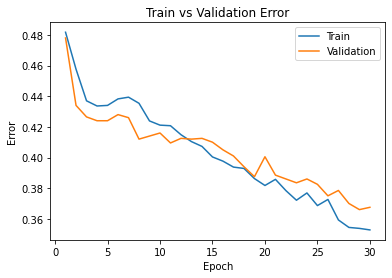

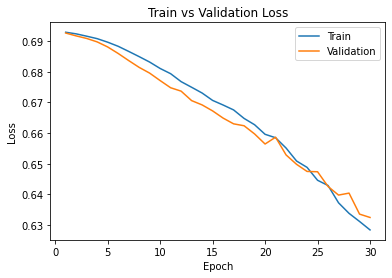

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=512)
lmodel_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(lmodel_path)


#the model takes less time to train, new elapsed time is 105.25 sec
#increasing the batch size decreases the time taken to train, 
#and produces a much more similiar validation curve to traning curve
#this indicates the the training data does not overfit and creates
#a general enough model that can perform well on new validation data
#for both error and loss


### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774821187257767 |Validation err: 0.378, Validation loss: 0.651921395778656
Epoch 2: Train err: 0.36875, Train loss: 0.6395755406022072 |Validation err: 0.3595, Validation loss: 0.6264406447410583
Epoch 3: Train err: 0.33875, Train loss: 0.6120929001569748 |Validation err: 0.3475, Validation loss: 0.6289729187488556
Epoch 4: Train err: 0.314375, Train loss: 0.5869516692757607 |Validation err: 0.3545, Validation loss: 0.6142054274082184
Epoch 5: Train err: 0.3115, Train loss: 0.5694829801917076 |Validation err: 0.312, Validation loss: 0.5763112711906433
Epoch 6: Train err: 0.281125, Train loss: 0.5458917077481746 |Validation err: 0.2985, Validation loss: 0.5741617560386658
Epoch 7: Train err: 0.269875, Train loss: 0.5297637034058571 |Validation err: 0.309, Validation loss: 0.6013907868862152
Epoch 8: Train err: 0.257375, Train loss: 0.5129605046510697 |Validation err: 0

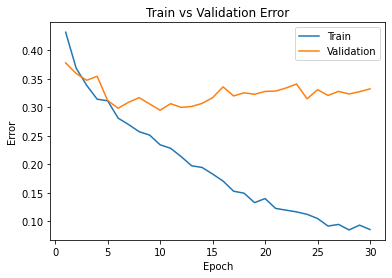

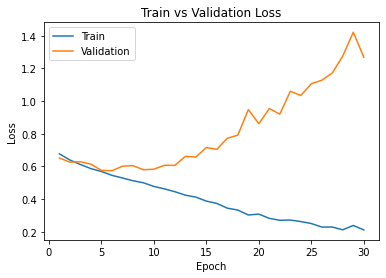

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=16)
lmodel_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(lmodel_path)

#decreasing the batch size had negative effects on both time to train and training curve
#the time to train took 155.21 seconds, significantly longer than the default batch size time
#in addition, the validation curve for both error and loss is drastically different from the
#training curve, suggesting that the model was not general enough adn hence
#could not perform well on new data, the model training was likely underfit
#due to small of batch size 



## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [ ]:
#initial hypothesis : i believe that using the large_net and larger batch size will improve the validation accuracy.
# upon running with these parameters, i have found the best validation error produced in 30 epoch was 0.293
#which is just as good as the default paramater values for the large network
# upon trying other values I am believing that the initial default parameters for the large batch size
# are very good and wont be improving much more

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.454375, Train loss: 0.6920222535965934 |Validation err: 0.426, Validation loss: 0.6897580400109291
Epoch 2: Train err: 0.44475, Train loss: 0.6877933882531666 |Validation err: 0.4115, Validation loss: 0.6820726208388805
Epoch 3: Train err: 0.422, Train loss: 0.6812239989401803 |Validation err: 0.412, Validation loss: 0.6738845333456993
Epoch 4: Train err: 0.41025, Train loss: 0.6737808935225956 |Validation err: 0.4075, Validation loss: 0.6660195551812649
Epoch 5: Train err: 0.397, Train loss: 0.6661106366959829 |Validation err: 0.401, Validation loss: 0.6589444242417812
Epoch 6: Train err: 0.3765, Train loss: 0.6566641018504188 |Validation err: 0.389, Validation loss: 0.6511358879506588
Epoch 7: Train err: 0.374875, Train loss: 0.648662491450234 |Validation err: 0.3755, Validation loss: 0.6394486390054226
Epoch 8: Train err: 0.359125, Train loss: 0.636394875390189 |Validation err: 0.3685, 

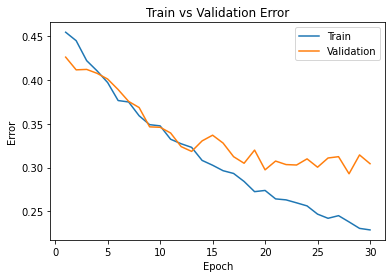

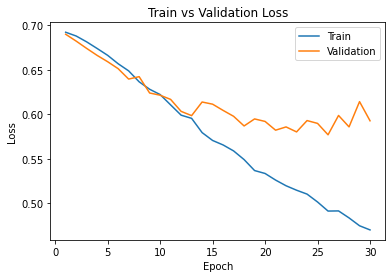

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=128, learning_rate=0.01)
b_model_path = get_model_name("large", batch_size=128, learning_rate=0.01, epoch=29)
plot_training_curve(b_model_path)


### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

In [ ]:
#based on not being able to find many other combinations in part a that made the results better, I will try minorly adjusting
#the default parameters in the large network and see the results. 

#new parameters, net : large_net, batch_size: 75, learning_rate: 0.0125, epochs: 30


### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.445125, Train loss: 0.6899382928821528 |Validation err: 0.4295, Validation loss: 0.6802847826922381
Epoch 2: Train err: 0.417875, Train loss: 0.677430251491404 |Validation err: 0.41, Validation loss: 0.6738588191844799
Epoch 3: Train err: 0.39675, Train loss: 0.664011515189554 |Validation err: 0.3925, Validation loss: 0.6506264496732641
Epoch 4: Train err: 0.37225, Train loss: 0.645300905838191 |Validation err: 0.399, Validation loss: 0.6643057995372348
Epoch 5: Train err: 0.350625, Train loss: 0.6289925291159443 |Validation err: 0.354, Validation loss: 0.6258335621268661
Epoch 6: Train err: 0.334625, Train loss: 0.6114959404847332 |Validation err: 0.3345, Validation loss: 0.6126362063266613
Epoch 7: Train err: 0.32125, Train loss: 0.5947445062833412 |Validation err: 0.333, Validation loss: 0.6056483465212362
Epoch 8: Train err: 0.311625, Train loss: 0.5779890794063283 |Validation err: 0.3

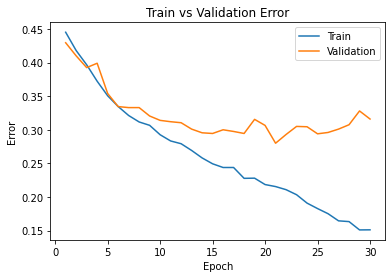

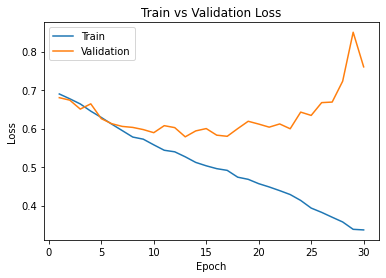

In [ ]:

large_net = LargeNet()
train_net(large_net, batch_size=75, learning_rate=0.0125)
l_model_path = get_model_name("large", batch_size=75, learning_rate=0.0125, epoch=29)
plot_training_curve(l_model_path)

#this set of parameters yielded the lowest validation error yet of 0.28, so it is my best model

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=75, learning_rate=0.0125, epoch=29)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

In [ ]:
#i chose this model as it yielded the lowest validation error in all of my model variation trials
#using the large network I have more to work with, these hyperparametrs are very close to the 
#default values, which to begin with presented low error values

#the lower vlaidation error means the parameters I chose to tune the model with yeild better more accurate
#results with less error


### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=75)

evaluate(net, test_loader, criterion=nn.BCEWithLogitsLoss())

#the output is (0.317, 0.7137431601683298), error : 0.317

Files already downloaded and verified
Files already downloaded and verified


(0.317, 0.7137431601683298)

### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [ ]:
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=75)

evaluate(net, val_loader, criterion=nn.BCEWithLogitsLoss())

#the output is : (0.316, 0.7633504779250534)
#i expect the test error to be higher as the model has never seen the test data values before!
#the validation data has been used and so the model may have learned how to deal with this data
#the testing data is exposed to the model for the first time, the model must apply its
#general abilities on it and the yielding error is most likely higher, which here it is

Files already downloaded and verified
Files already downloaded and verified


(0.316, 0.7633504779250534)

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

In [ ]:
#it is important to use the test data as little as possible because it used as a final assessment
#testset is used to test in most general manner the final chosen model
#as the model has never seen this final data set before
#where as the training data is used to train the model, the validation set used to tune the 
#parameters, so the model is familiar with those sets and may over fit to them
#by using a fresh data set the model can illustrate its true performace on new data

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [ ]:
#here I am creating a ANN as used in lab 1
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim
import numpy as np

torch.manual_seed(1) # set the random seed

# define a 2-layer artificial neural network
class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.layer1 = nn.Linear(32*32*3,30)
        self.layer2 = nn.Linear(30, 1)

        self.name = "pigeon"

       
    def forward(self, img):
        flattened = img.view(-1, 32*32*3)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2.squeeze(1)
        return activation2

train_net(net)

#now evualte it
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=75
)
evaluate(net, test_loader, criterion=nn.BCEWithLogitsLoss())


#evualate first output is : (0.313, 1.60664701461792)
#the ANN error is lower, 0.313 < 0.317, this shows how this model yields greater results


        




Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.04725, Train loss: 0.13037879472970962 |Validation err: 0.3365, Validation loss: 1.8173626251518726
Epoch 2: Train err: 0.0355, Train loss: 0.09883867706358433 |Validation err: 0.3215, Validation loss: 2.240603778511286
Epoch 3: Train err: 0.0245, Train loss: 0.06942185962945223 |Validation err: 0.327, Validation loss: 2.1621758714318275
Epoch 4: Train err: 0.0165, Train loss: 0.044054711595177654 |Validation err: 0.324, Validation loss: 2.3447097204625607
Epoch 5: Train err: 0.027625, Train loss: 0.0711747020855546 |Validation err: 0.334, Validation loss: 2.3411936312913895
Epoch 6: Train err: 0.029875, Train loss: 0.08250984904915094 |Validation err: 0.3505, Validation loss: 2.455385636538267
Epoch 7: Train err: 0.050375, Train loss: 0.139184285774827 |Validation err: 0.338, Validation loss: 2.29196485504508
Epoch 8: Train err: 0.0405, Train loss: 0.10773460979759693 |Validation err: 0.3

(0.3, 2.6929131702140525)

In [ ]:
#now evualte it
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=75
)
evaluate(net, test_loader, criterion=nn.BCEWithLogitsLoss())

Files already downloaded and verified
Files already downloaded and verified


(0.313, 1.60664701461792)